# Preparación de los datos para la LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
from matplotlib import pyplot

In [2]:
# Cargando el conjunto de Datos
df = pd.read_csv('TRM-SIN-DIAS.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['Fecha','TRM'])
df.head()


Fecha
2020-08-04    3910.15
2020-09-04    3886.79
2020-10-04    3886.79
2020-11-04    3886.79
2020-12-04    3886.79
Name: TRM, dtype: float64

In [3]:
df.describe()

count     479.000000
mean     3700.602046
std       138.541267
min      3410.820000
25%      3611.440000
50%      3709.000000
75%      3791.335000
max      4046.040000
Name: TRM, dtype: float64

In [4]:
print(df.index.min())
print(df.index.max())

2020-01-05 00:00:00
2021-12-07 00:00:00


In [ ]:
print(len(df['2020']))
print(len(df['2021']))

267
212


In [5]:
meses =df.resample('M').mean()
meses

Fecha
2020-01-31    3775.272500
2020-02-29    3756.071250
2020-03-31    3738.083750
2020-04-30    3901.326538
2020-05-31    3792.890000
2020-06-30    3734.898846
2020-07-31    3675.015926
2020-08-31    3783.007037
2020-09-30    3765.286667
2020-10-31    3790.786429
2020-11-30    3662.620741
2020-12-31    3538.423214
2021-01-31    3551.095000
2021-02-28    3583.507391
2021-03-31    3615.013077
2021-04-30    3647.069200
2021-05-31    3696.162692
2021-06-30    3701.572400
2021-07-31    3791.976154
2021-08-31    3638.891429
2021-09-30    3643.344286
2021-10-31    3641.934286
2021-11-30    3625.952857
2021-12-31    3621.012857
Freq: M, Name: TRM, dtype: float64

#Preparación de los datos LSTM

In [6]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.572148,0.498599,0.498599,0.498599,0.498599,0.498599,0.446712,0.408614
8,0.498599,0.498599,0.498599,0.498599,0.498599,0.446712,0.408614,0.605775
9,0.498599,0.498599,0.498599,0.498599,0.446712,0.408614,0.605775,0.675325
10,0.498599,0.498599,0.498599,0.446712,0.408614,0.605775,0.675325,0.770222
11,0.498599,0.498599,0.446712,0.408614,0.605775,0.675325,0.770222,0.770222


# Dividimos el conjunto de entrenamiento y validación

In [7]:
# split into train and test sets
values = reframed.values
n_train_days = 369
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(369, 1, 7) (369,) (103, 1, 7) (103,)


## Creamos la red neuronal

In [8]:
def crear_modeloLSTM():
    model = Sequential() 
    model.add(LSTM(7, return_sequences=True, input_shape=(1,PASOS),activation='tanh'))
    model.add(LSTM(5, return_sequences=True, activation='tanh',kernel_regularizer=l2(0.05), recurrent_regularizer=l2(0.05), bias_regularizer=l2(0.05)))
    model.add(LSTM(3, return_sequences=True, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [9]:
EPOCHS=60

model = crear_modeloLSTM()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 7)              420       
                                                                 
 lstm_1 (LSTM)               (None, 1, 5)              260       
                                                                 
 lstm_2 (LSTM)               (None, 1, 3)              108       
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
53/53 [==============================] - 7s 29m

## Visualización de Resultados

103


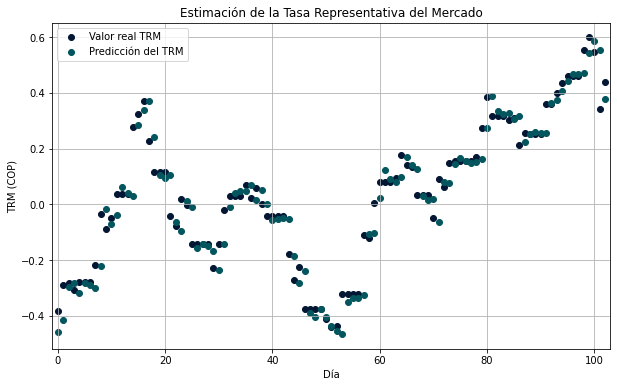

In [10]:
results=model.predict(x_val)
print( len(results) )
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_val)),y_val,color="#031634",label="Valor real TRM")
plt.scatter(range(len(results)),results,color="#03565E",label="Predicción del TRM")
plt.title('Estimación de la Tasa Representativa del Mercado')
plt.xlabel('Día')
plt.ylabel('TRM (COP)')
plt.legend()
plt.xlim(-1,103)
plt.grid()
plt.show()

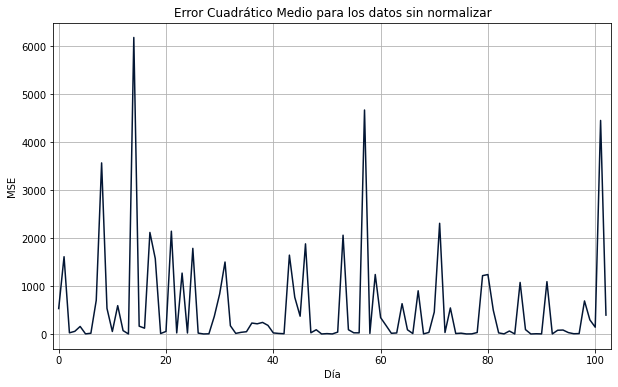

In [11]:
n=len(results)
MSE=np.zeros(n)
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
MSEsum=0
for i in range(0,len(results)):
  MSE[i] = (compara2['real'][i] - compara2['prediccion'][i])**2
  MSEsum = np.sum(MSE)/n
plt.figure(figsize=(10,6))
plt.plot(range(len(results)),MSE, color="#031634")
plt.title('Error Cuadrático Medio para los datos sin normalizar')
plt.xlabel('Día')
plt.ylabel('MSE')
plt.xlim(-1,103)
plt.grid()
plt.show()

In [12]:
print('El MSE es de %0.3f' % MSEsum)

El MSE es de 555.912


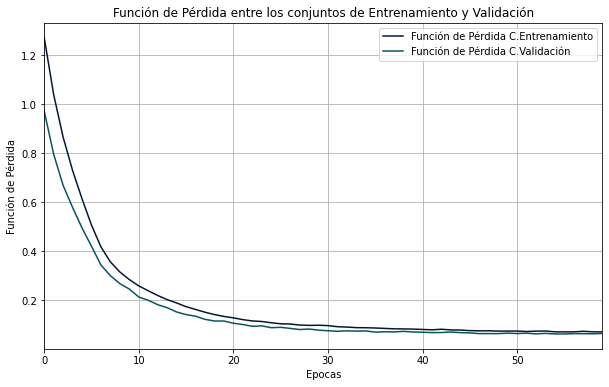

In [13]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color="#031634",label="Función de Pérdida C.Entrenamiento")
plt.plot(history.history['val_loss'], color="#03565E" ,label="Función de Pérdida C.Validación")
plt.title('Función de Pérdida entre los conjuntos de Entrenamiento y Validación')
plt.ylabel('Función de Pérdida')
plt.xlabel('Epocas')
plt.legend()
plt.xlim(0,59)
plt.grid()
plt.show()

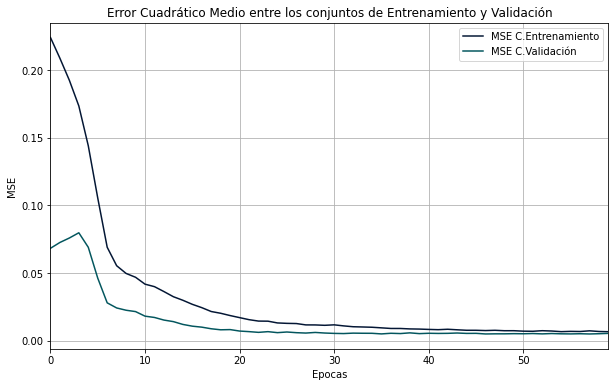

In [14]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mse'], color="#031634", label="MSE C.Entrenamiento")
plt.plot(history.history['val_mse'], color="#03565E", label="MSE C.Validación")
plt.title('Error Cuadrático Medio entre los conjuntos de Entrenamiento y Validación')
plt.ylabel('MSE')
plt.xlabel('Epocas')
plt.xlim(0,59)
plt.legend()
plt.grid()
plt.show()

In [15]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,3606.419922,3583.404297,23.015625
1,3636.260010,3596.131348,40.128662
2,3639.120117,3634.219482,4.900635
3,3630.810059,3638.215088,-7.405029
4,3640.069824,3627.549072,12.520752
5,3640.069824,3638.472168,1.597656
6,3640.069824,3636.170166,3.899658
7,3659.620117,3633.130371,26.489746
8,3717.459961,3657.747314,59.712646
9,3699.739990,3722.832031,-23.092041


In [16]:
compara2.describe()

,real,prediccion,diferencia
count,103.000000,103.000000,103.000000
mean,3740.692871,3737.272949,3.420237
std,81.083893,83.845230,23.442474
min,3588.409912,3580.648682,-66.709961
25%,3682.840088,3679.707764,-4.729492
50%,3739.030029,3740.810791,2.342285
75%,3804.395020,3802.250366,12.637085
max,3918.489990,3914.066650,78.610840


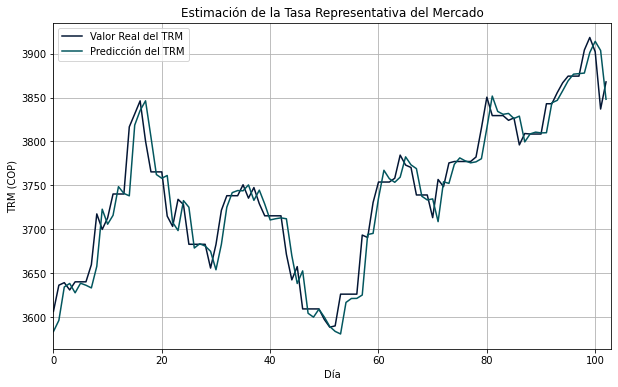

In [17]:
plt.figure(figsize=(10,6))
compara2['real'].plot(color="#031634",label="Valor Real del TRM")
compara2['prediccion'].plot( color="#03565E",label="Predicción del TRM")
plt.title('Estimación de la Tasa Representativa del Mercado')
plt.xlabel('Día')
plt.ylabel('TRM (COP)')
plt.legend()
plt.xlim(0,103)
plt.grid()
plt.show()

## PRONOSTICO
A partir de los últimos tres meses del 2021, intentaremos predecir el mes de Agosto.

In [18]:
ultimosDias = df['2021-05-01':'2021-07-31']
ultimosDias

Fecha
2021-05-01    3420.78
2021-06-01    3450.74
2021-07-01    3428.04
2021-05-02    3558.63
2021-06-02    3543.28
               ...   
2021-07-27    3904.17
2021-07-28    3918.49
2021-07-29    3902.18
2021-07-30    3836.95
2021-07-31    3867.88
Name: TRM, Length: 77, dtype: float64

## Preparamos los datos para Test

In [19]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,-0.879608,-0.970826,-0.446063,-0.507745,-0.507745,-0.086978
8,-0.879608,-0.970826,-0.446063,-0.507745,-0.507745,-0.086978,-0.118281
9,-0.970826,-0.446063,-0.507745,-0.507745,-0.086978,-0.118281,-0.118281
10,-0.446063,-0.507745,-0.507745,-0.086978,-0.118281,-0.118281,0.036106
11,-0.507745,-0.507745,-0.086978,-0.118281,-0.118281,0.036106,-0.095819
12,-0.507745,-0.086978,-0.118281,-0.118281,0.036106,-0.095819,-0.098431
13,-0.086978,-0.118281,-0.118281,0.036106,-0.095819,-0.098431,0.649837


In [20]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(64, 1, 7)


array([[[-0.08697796, -0.11828136, -0.11828136,  0.03610611,
         -0.09581852, -0.09843063,  0.64983654]],

       [[-0.11828136, -0.11828136,  0.03610611, -0.09581852,
         -0.09843063,  0.64983654,  0.70983124]],

       [[-0.11828136,  0.03610611, -0.09581852, -0.09843063,
          0.64983654,  0.70983124,  0.5251856 ]],

       [[ 0.03610611, -0.09581852, -0.09843063,  0.64983654,
          0.70983124,  0.5251856 ,  0.2590065 ]],

       [[-0.09581852, -0.09843063,  0.64983654,  0.70983124,
          0.5251856 ,  0.2590065 ,  0.23489666]],

       [[-0.09843063,  0.64983654,  0.70983124,  0.5251856 ,
          0.2590065 ,  0.23489666,  0.05306339]],

       [[ 0.64983654,  0.70983124,  0.5251856 ,  0.2590065 ,
          0.23489666,  0.05306339,  0.05306339]],

       [[ 0.70983124,  0.5251856 ,  0.2590065 ,  0.23489666,
          0.05306339,  0.05306339,  0.05306339]],

       [[ 0.5251856 ,  0.2590065 ,  0.23489666,  0.05306339,
          0.05306339,  0.05306339,  0.05306

In [21]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para el próximo mes

In [22]:
results=[]
for i in range(31):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

Se han truncado las últimas 5000 líneas del flujo de salida.
    0.5578556   0.5578556 ]]

 [[ 0.6317539   0.50806713  0.56030655  0.5578556   0.5578556
    0.5578556   0.69653034]]

 [[ 0.50806713  0.56030655  0.5578556   0.5578556   0.5578556
    0.69653034  0.69653034]]

 [[ 0.56030655  0.5578556   0.5578556   0.5578556   0.69653034
    0.69653034  0.74760437]]

 [[ 0.5578556   0.5578556   0.5578556   0.69653034  0.69653034
    0.74760437  0.792531  ]]

 [[ 0.5578556   0.5578556   0.69653034  0.69653034  0.74760437
    0.792531    0.82298946]]

 [[ 0.5578556   0.69653034  0.69653034  0.74760437  0.792531
    0.82298946  0.82298946]]

 [[ 0.69653034  0.69653034  0.74760437  0.792531    0.82298946
    0.82298946  0.82298946]]

 [[ 0.69653034  0.74760437  0.792531    0.82298946  0.82298946
    0.82298946  0.94245625]]

 [[ 0.74760437  0.792531    0.82298946  0.82298946  0.82298946
    0.94245625  1.        ]]

 [[ 0.792531    0.82298946  0.82298946  0.82298946  0.94245625
    1.       

In [23]:
# Re-Convertimos los resultados
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.5763933], dtype=float32), array([0.57409084], dtype=float32), array([0.5446601], dtype=float32), array([0.5271033], dtype=float32), array([0.51637137], dtype=float32), array([0.5054491], dtype=float32), array([0.518373], dtype=float32), array([0.5265858], dtype=float32), array([0.5333302], dtype=float32), array([0.5383765], dtype=float32), array([0.5418904], dtype=float32), array([0.5447192], dtype=float32), array([0.5471682], dtype=float32), array([0.5493212], dtype=float32), array([0.5511765], dtype=float32), array([0.552743], dtype=float32), array([0.55404454], dtype=float32), array([0.55512], dtype=float32), array([0.556009], dtype=float32), array([0.5567449], dtype=float32), array([0.5573545], dtype=float32), array([0.5578592], dtype=float32), array([0.5582765], dtype=float32), array([0.5586211], dtype=float32), array([0.5589054], dtype=float32), array([0.5591399], dtype=float32), array([0.5593332], dtype=float32), array([0.5594924], dtype=float32), array([0.55962354], d

array([[3813.07326416],
       [3812.50028356],
       [3805.17629543],
       [3800.80720156],
       [3798.13650591],
       [3795.41844876],
       [3798.63462479],
       [3800.67842221],
       [3802.35679599],
       [3803.6125949 ],
       [3804.48703963],
       [3805.19100968],
       [3805.80044958],
       [3806.33622923],
       [3806.79793331],
       [3807.18777193],
       [3807.51166342],
       [3807.77929367],
       [3808.00052657],
       [3808.18365371],
       [3808.33536475],
       [3808.46095502],
       [3808.56480025],
       [3808.65056415],
       [3808.72131714],
       [3808.77966982],
       [3808.82777296],
       [3808.86739167],
       [3808.90002408],
       [3808.92691615],
       [3808.94906169]])

## Visualizamos el Pronóstico

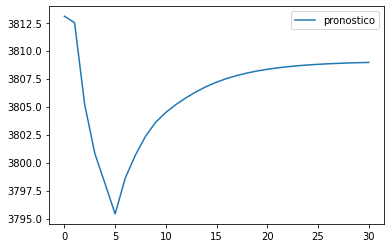

In [24]:
prediccionAgostoUCI = pd.DataFrame(inverted)
prediccionAgostoUCI.columns = ['pronostico']
prediccionAgostoUCI.plot()
prediccionAgostoUCI.to_csv('pronostico-TRM-Regularización l2.csv')

In [ ]:
prediccion1SemanaDiciembre

,pronostico
0,3791.531803
1,3787.986662
2,3776.771185
3,3783.275203
4,3782.591420
5,3759.658431
6,3765.864203
7,3766.791920
8,3770.365399
9,3770.092770
